In [14]:
import os
import sys

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import torch
import torchvision
from PIL import Image

import context
from config import get_config, default_config
from inference import predict_spectral
from models import (
    ToDCTTensor,
    ConvertDCTtoRGB,
    InverseDCT,
    Local2DAttentionLayer,
    SpectralNet,
    ChromaNet,
    Blockify,
    LayerNorm2D
)
from builders import build_chroma_net, build_spectral_net, build_dataloader, build_spectral_model, get_dct_stats
from jpegutils import JPEGTransforms, SUBSAMPLE_FACTORS
from utils import load_checkpoint

In [2]:
%load_ext autoreload
%autoreload 2

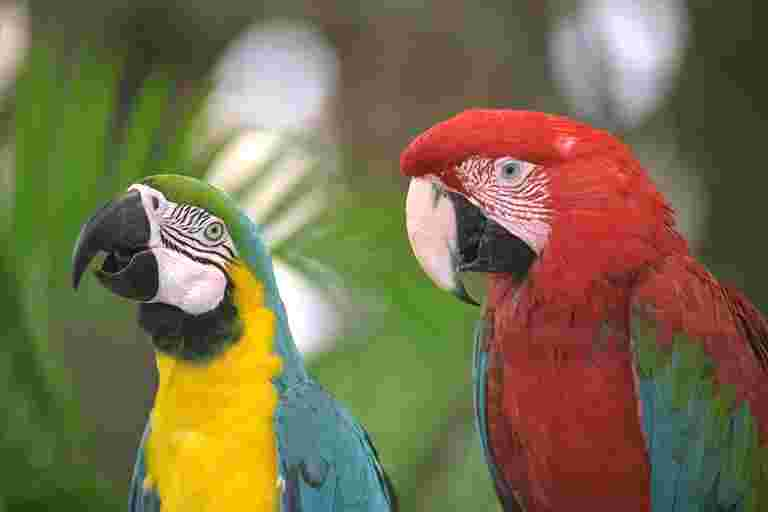

In [3]:
SAMPLE_IMAGE = Image.open("../data/Live1-Classic5/live1/color/qf_10/parrots.jpg")
SAMPLE_IMAGE

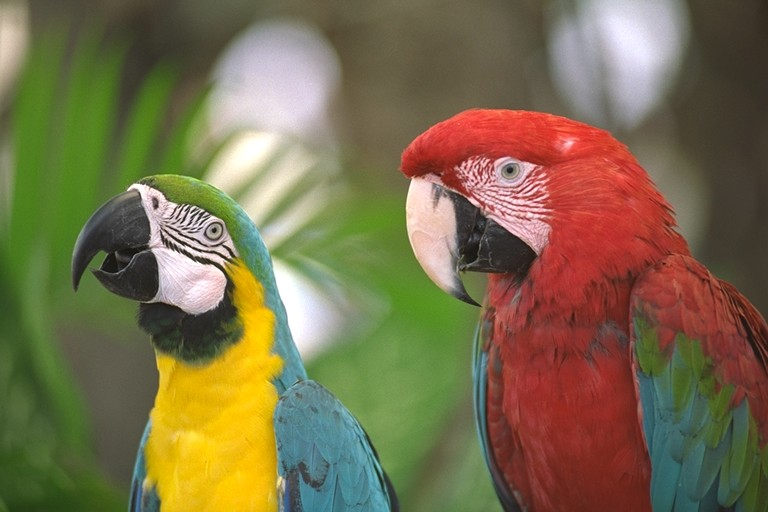

In [4]:
TRAIN_IMAGE = SAMPLE_IMAGE
TARGET_IMAGE = Image.open("../data/Live1-Classic5/live1/color/qf_90/parrots.jpg")
TARGET_IMAGE

#### Load DCT stats

In [5]:
cfg = default_config()
cfg.DATA.DCT_STATS_FILEPATH = "../data/DIV2K+Flickr2K-dct-stats.json"
DCT_STATS = get_dct_stats(cfg)

In [272]:
WINDOW_SIZE = 9
EMBED_DIM = 25
NUM_HEADS = 5
BLOCK_SIZE = 5

#### Initialize transforms

In [273]:
toten = torchvision.transforms.ToTensor()
jpegT = JPEGTransforms(np.array(TRAIN_IMAGE))
torgb = ConvertDCTtoRGB()
toycc = InverseDCT(**DCT_STATS)
toblocks = Blockify(8)
rgb10 = torchvision.transforms.ToTensor()(SAMPLE_IMAGE)
todcten = ToDCTTensor(**DCT_STATS)
self_attn = Local2DAttentionLayer(WINDOW_SIZE, embed_dim=64, num_heads=1)

### Define model

In [274]:
class TinyAttention(torch.nn.Module):

    def __init__(self):
        super().__init__()
        self.attn = Local2DAttentionLayer(WINDOW_SIZE, embed_dim=EMBED_DIM, num_heads=NUM_HEADS)
        self.idct = InverseDCT(**DCT_STATS)
        self._last_attn_scores = None

    def forward(self, x):
        y, scores = self.attn(x)
        self._last_attn_scores = scores.detach()
        return self.idct(y, False)


class TinyAttentionSpatial(torch.nn.Module):

    def __init__(self):
        super().__init__()
        self.blockify = Blockify(BLOCK_SIZE)
        self.num_layers = 8
        self.attn = torch.nn.ModuleList(
            [Local2DAttentionLayer(WINDOW_SIZE, embed_dim=BLOCK_SIZE ** 2, num_heads=NUM_HEADS) for _ in range(self.num_layers)]
        )
        self.activations = torch.nn.ModuleList([torch.nn.GELU() for _ in range(self.num_layers)])

        self.norms = torch.nn.ModuleList([LayerNorm2D(BLOCK_SIZE ** 2) for _ in range(self.num_layers)])
        self._last_attn_scores = None
        for i in range(self.num_layers):
            torch.nn.init.trunc_normal_(self.attn[i].project_k.weight, std=0.1)
            torch.nn.init.trunc_normal_(self.attn[i].project_q.weight, std=0.1)
            torch.nn.init.trunc_normal_(self.attn[i].project_v.weight, std=0.1)
            
            

    def forward(self, x):
        N, _, H, W = x.shape
        # N, 1, H, W
        blocks = self.blockify(x, True)
        # N, 1, h, w, E
        y = blocks.squeeze(1).permute(0,3,1,2)
        # N, E, h, w
        for i in range(self.num_layers):
            w, _ = self.attn[i](y)
            y = y + self.activations[i](w)
            y = self.norms[i](y)
        _, _, h, w = y.shape
        z = y.reshape(N, BLOCK_SIZE, BLOCK_SIZE, h, w)
        z = z.permute(0, 3, 1, 4, 2)
        z = z.reshape(N, 1, H, W)
        return x + z

### Init Dataset

In [275]:
# Input
jpegT = JPEGTransforms(np.array(TRAIN_IMAGE)[100:300, 100:300])
dctY, dctCb, dctCr = jpegT.get_dct_planes(subsample=444)
dctY_train = todcten(dctY, chroma=False).unsqueeze(0)
luma = jpegT.get_upsampled_ycc_planes(subsample=444)[0]

# Target
jpegT = JPEGTransforms(np.array(TARGET_IMAGE)[100:300, 100:300])
# dctY, dctCb, dctCr = jpegT.get_dct_planes(subsample=444)
# dctY_target = ToDCTTensor()(dctY, chroma=False).unsqueeze(0)
luma_target = toten(jpegT.get_ycc_planes(444)[0]).unsqueeze(0)

# batch = (dctY_train, luma_target)
batch = (toten(luma).unsqueeze(0), luma_target)

In [276]:
batch[0].shape

torch.Size([1, 1, 200, 200])

#### Train loop

In [277]:
model = TinyAttentionSpatial()
optim = torch.optim.AdamW(model.parameters(), lr=1e-2)

In [278]:
model(batch[0]).std()

tensor(1.0547, grad_fn=<StdBackward0>)

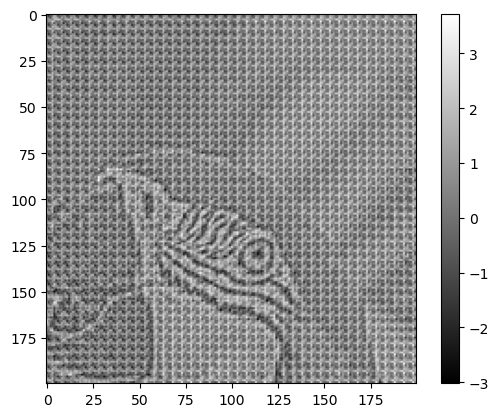

In [279]:
fig, ax = plt.subplots()
c = ax.imshow(model(batch[0])[0,0].detach().numpy(), cmap="gray")
fig.colorbar(c)

In [280]:
train, target = batch
pred = model(train)
loss = torch.nn.functional.mse_loss(pred, target)
loss.backward()

In [281]:
model.attn[2].project_v.weight.grad.std()

tensor(9.2571e-05)

In [288]:
optim.param_groups[0]["lr"] = 8e-3

In [289]:
pred_history = []

for i in range(10_000):
    optim.zero_grad()
    train, target = batch
    pred = model(train)
    loss = torch.nn.functional.mse_loss(pred, target)
    loss.backward()
    optim.step()
    if i % 10 == 0:
        print(f"Train iteration [{i:>5}/{4000:>5}]: loss={loss.item():.6f}")
        pred_history.append(pred.detach().numpy()[0,0])

Train iteration [    0/ 4000]: loss=0.001264
Train iteration [   10/ 4000]: loss=0.001554
Train iteration [   20/ 4000]: loss=0.001405
Train iteration [   30/ 4000]: loss=0.001336
Train iteration [   40/ 4000]: loss=0.001285
Train iteration [   50/ 4000]: loss=0.001268
Train iteration [   60/ 4000]: loss=0.001246
Train iteration [   70/ 4000]: loss=0.001298
Train iteration [   80/ 4000]: loss=0.001307
Train iteration [   90/ 4000]: loss=0.001253
Train iteration [  100/ 4000]: loss=0.001225
Train iteration [  110/ 4000]: loss=0.001233
Train iteration [  120/ 4000]: loss=0.001245
Train iteration [  130/ 4000]: loss=0.001222
Train iteration [  140/ 4000]: loss=0.001204
Train iteration [  150/ 4000]: loss=0.001197
Train iteration [  160/ 4000]: loss=0.001222
Train iteration [  170/ 4000]: loss=0.001202
Train iteration [  180/ 4000]: loss=0.001195
Train iteration [  190/ 4000]: loss=0.001191
Train iteration [  200/ 4000]: loss=0.001204
Train iteration [  210/ 4000]: loss=0.001196
Train iter

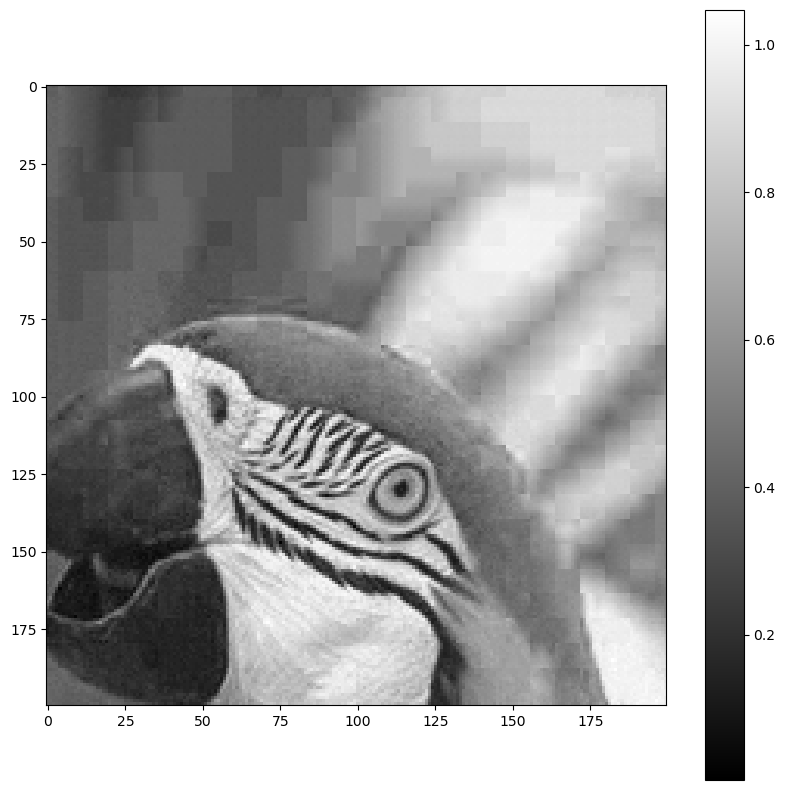

In [271]:
c = plt.imshow(pred_history[-1], cmap="gray")
plt.colorbar(c)
plt.gcf().set_size_inches(10,10)

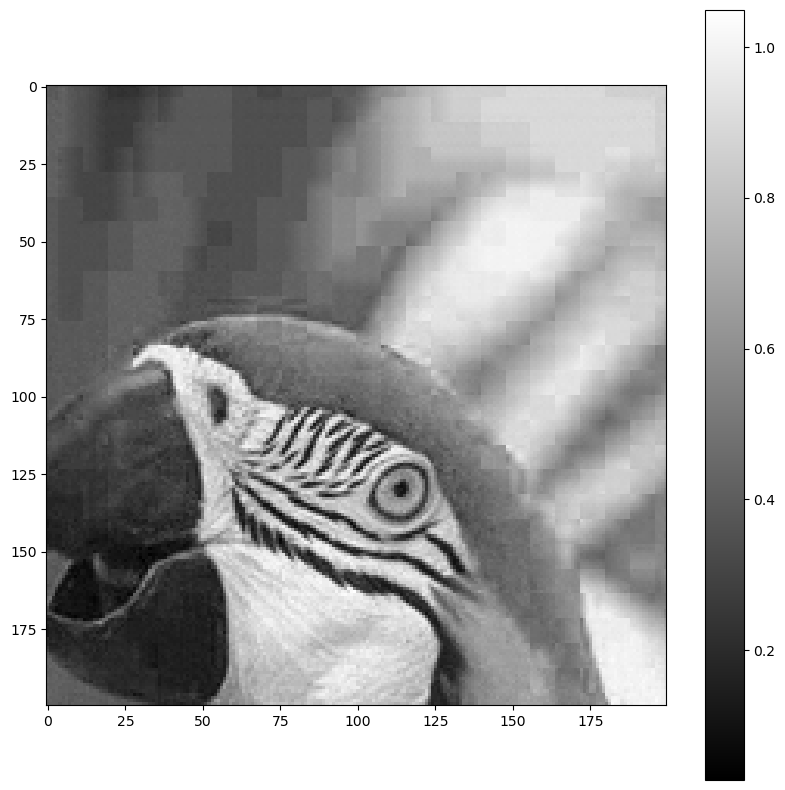

In [290]:
c = plt.imshow(pred_history[-1], cmap="gray")
plt.colorbar(c)
plt.gcf().set_size_inches(10,10)

In [298]:
with torch.no_grad():
    print(model(batch[0]))

tensor([[[[0.3891, 0.3741, 0.3788,  ..., 0.8386, 0.8399, 0.8488],
          [0.4075, 0.3786, 0.3828,  ..., 0.8596, 0.8614, 0.8648],
          [0.3933, 0.3832, 0.3964,  ..., 0.8544, 0.8660, 0.8636],
          ...,
          [0.4302, 0.4038, 0.4058,  ..., 1.0000, 0.9793, 0.9849],
          [0.4108, 0.4248, 0.4060,  ..., 0.9937, 0.9920, 0.9914],
          [0.4006, 0.4150, 0.4147,  ..., 0.9972, 0.9848, 0.9742]]]])


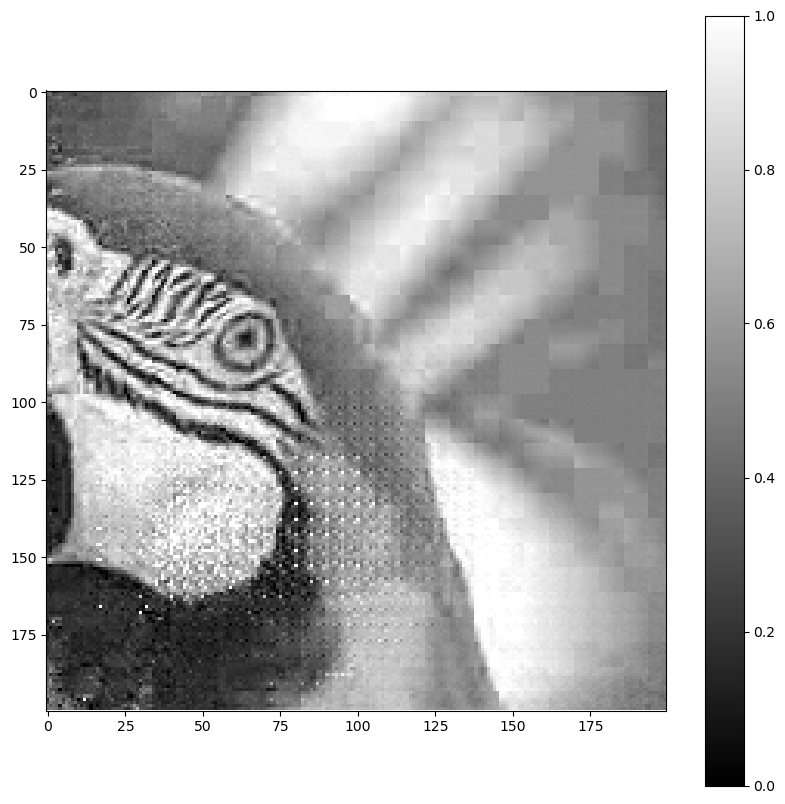

In [302]:
with torch.no_grad():
    jpegT = JPEGTransforms(np.array(TRAIN_IMAGE)[150:350, 150:350])
    x = toten(jpegT.get_ycc_planes(444)[0]).unsqueeze(0)
    y = model(x).numpy()
    plt.imshow(y[0,0], cmap="gray", vmin=0, vmax=1)
    plt.colorbar()
    plt.gcf().set_size_inches(10,10)

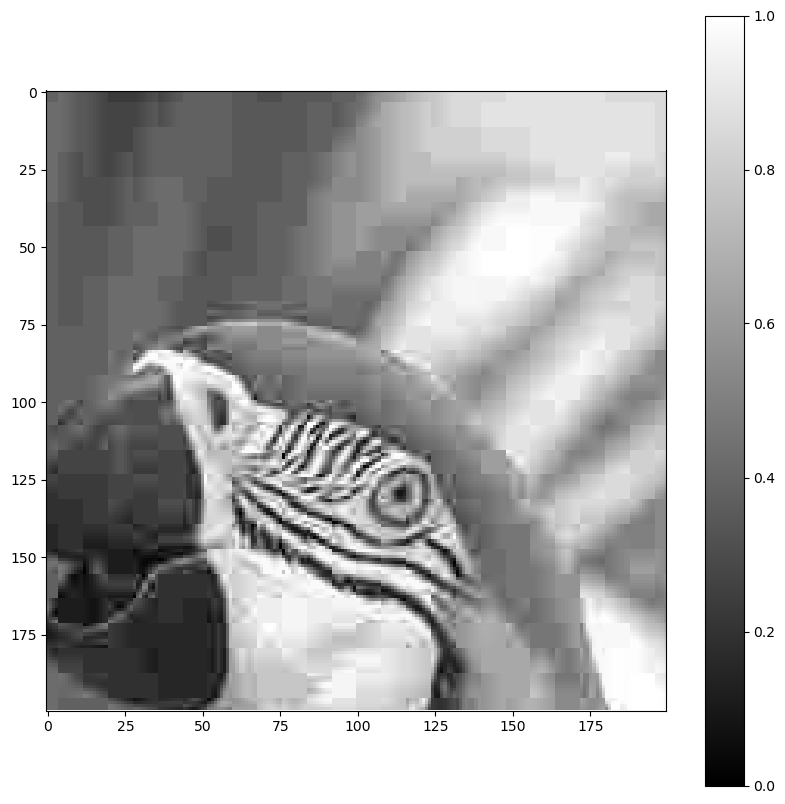

In [242]:
plt.imshow(batch[0].numpy()[0,0], cmap="gray")
plt.colorbar()
plt.gcf().set_size_inches(10,10)

In [86]:
blocks = toblocks(rgb10.unsqueeze(0), True)
blocks = blocks[0].permute(0,3,1,2)
blocks.shape

torch.Size([3, 64, 64, 96])

In [87]:
out, scores = self_attn(blocks)
out.shape

torch.Size([3, 64, 64, 96])

In [91]:
scores.mean(dim=1).view(3, WINDOW_SIZE, WINDOW_SIZE)

tensor([[[-0.0596, -0.0601, -0.0584],
         [-0.0603, -0.0616, -0.0598],
         [-0.0595, -0.0613, -0.0594]],

        [[-0.0420, -0.0423, -0.0412],
         [-0.0425, -0.0433, -0.0422],
         [-0.0418, -0.0431, -0.0417]],

        [[-0.0150, -0.0153, -0.0139],
         [-0.0152, -0.0163, -0.0148],
         [-0.0147, -0.0162, -0.0146]]], grad_fn=<ViewBackward0>)

In [77]:
dctY, dctCb, dctCr = jpegT.get_dct_planes(subsample=444)
dctY.shape

(64, 96, 8, 8)

In [78]:
dctY10 = ToDCTTensor()(dctY, chroma=False).unsqueeze(0)
dctY10.shape

torch.Size([1, 64, 64, 96])

In [79]:
res, scores = self_attn(dctY10)
res.shape

torch.Size([1, 64, 64, 96])

In [81]:
torch.nn.functional.softmax(scores.mean(dim=1)[-1].reshape(1,1), dim=1).detach().numpy().round(1)

array([[1.]], dtype=float32)

In [82]:
luma = toycc(res.contiguous(), chroma=False)
luma.shape

torch.Size([1, 1, 512, 768])

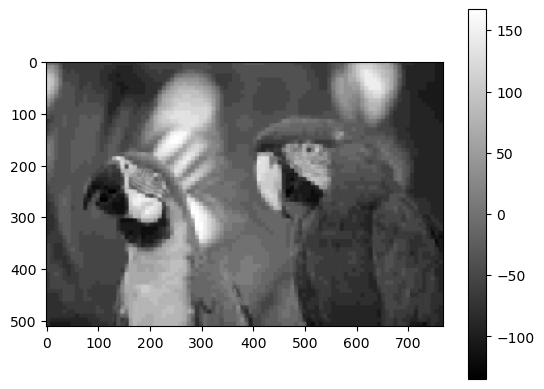

In [83]:
c = plt.imshow(luma[0,0].detach().numpy(), cmap="gray")
plt.colorbar(c)

In [58]:
dctY.shape

(64, 64, 8, 8)

In [88]:
def type2_harmonics(n):
    steps = (2 * np.arange(n) + 1) / (2 * n)
    f = np.arange(n)
    return np.cos(np.outer(steps, f * np.pi))

def type3_harmonics(n):
    steps = np.arange(n) / (2 * n)
    f = 2 * np.arange(n) + 1
    return np.cos(np.outer(steps, f * np.pi))

def dct_basis():
    h1 = type3_harmonics(8)
    h2 = type3_harmonics(8)
    basis = h1.T.reshape(8, 1, 8, 1) * h2.T.reshape(1,8,1,8)
    return basis

basis = dct_basis()

In [128]:
I = 0
J = 1

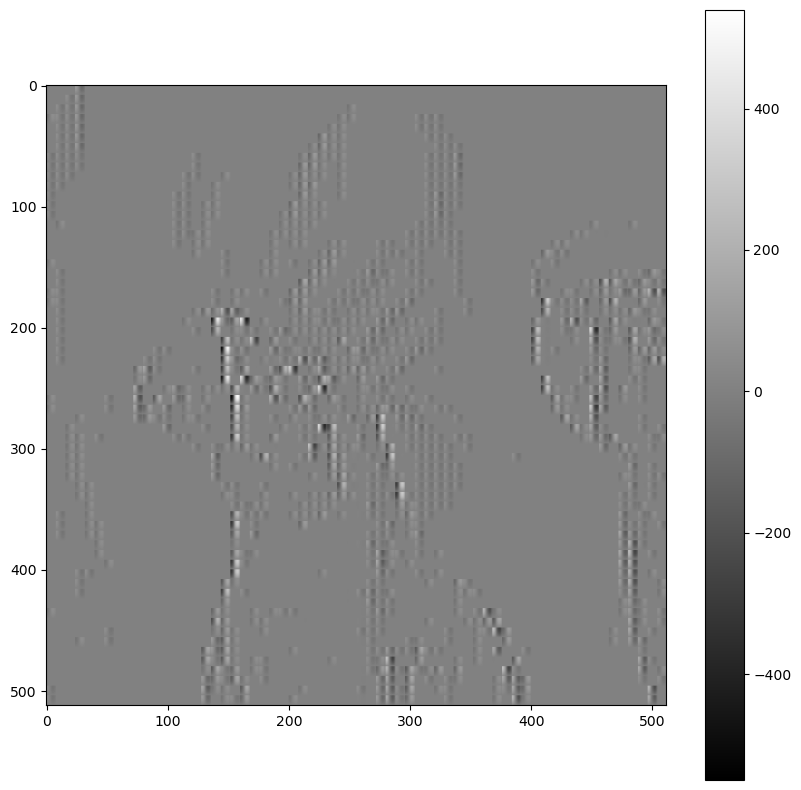

In [129]:
jpegT = JPEGTransforms(np.array(TRAIN_IMAGE)[:512, :512])
dctY, dctCb, dctCr = jpegT.get_dct_planes(subsample=444)
x = dctY[:,:,I:I+1,J:J+1] * basis[I,J]
x = x.transpose((0,2,1,3))
plt.imshow(x.reshape(512, 512), cmap="gray")
c = plt.gcf().set_size_inches(10, 10)
plt.colorbar(c)

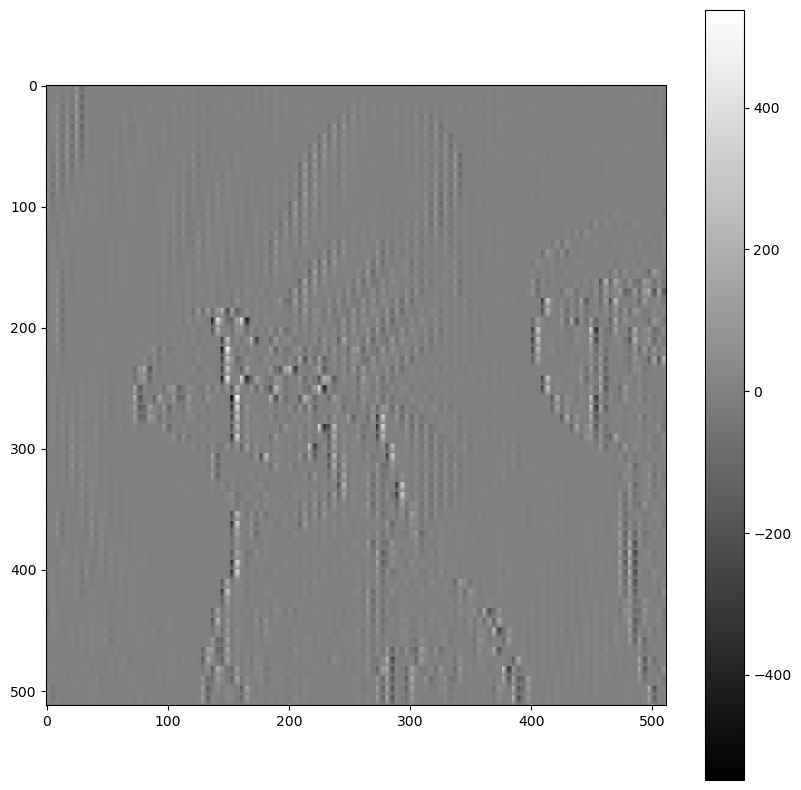

In [130]:
jpegT = JPEGTransforms(np.array(TARGET_IMAGE)[:512, :512])
dctY, dctCb, dctCr = jpegT.get_dct_planes(subsample=444)
x = dctY[:,:,I:I+1,J:J+1] * basis[I,J]
x = x.transpose((0,2,1,3))
plt.imshow(x.reshape(512, 512), cmap="gray")
c = plt.gcf().set_size_inches(10, 10)
plt.colorbar(c)